In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### The Gell-Mann matrices are shown here:

$$\displaystyle \hat{t}^{(1)} = \left(\begin{array}{ccc} 0 & 1 & 0 \\ 1 & 0 & 0\\ 0 & 0 & 0\end{array}\right) \;\;\;\;\;\;\;\;\;\; 
\hat{t}^{(2)} = \left(\begin{array}{ccc} 0 & -i & 0 \\ i & 0 & 0\\ 0 & 0 & 0\end{array}\right)\;\;\;\;\;\;\;\;\;\;\hat{t}^{(3)} = \left(\begin{array}{ccc} 1 & 0 & 0 \\ 0 & -1 & 0\\ 0 & 0 & 0\end{array}\right)$$
$$\hat{t}^{(4)} = \left(\begin{array}{ccc} 0 & 0 & 1 \\ 0 & 0 & 0\\ 1 & 0 & 0\end{array}\right)\;\;\;\;\;\;\;\;\;\;
\displaystyle \hat{t}^{(5)} = \left(\begin{array}{ccc} 0 & 0 & -i \\ 0 & 0 & 0\\ i & 0 & 0\end{array}\right) \;\;\;\;\;\;\;\;\;\;
\hat{t}^{(6)} = \left(\begin{array}{ccc} 0 & 0 & 0 \\ 0 & 0 & 1\\ 0 & 1 & 0\end{array}\right)$$
$$\hat{t}^{(7)} = \left(\begin{array}{ccc} 0 & 0 & 0 \\ 0 & 0 & -i\\ 0 & i & 0\end{array}\right)\;\;\;\;\;\;\;\;\;\; \hat{t}^{(8)} = \frac{1}{\sqrt{3}}\left(\begin{array}{ccc} 1 & 0 & 0 \\ 0 & 1 & 0\\ 0 & 0 & -2\end{array}\right)\\$$

For convenience, these are packaged as slices of a three-dimensional array. The $3\times 3$ identity matrix is also defined here and denoted $\hat{t}^{(0)}$.

In [2]:
gm_mats = np.zeros((9, 3, 3), dtype=np.complex128)
gm_mats[0] = np.eye(3)
gm_mats[1] = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
gm_mats[2] = np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]])
gm_mats[3] = np.diag([1, -1, 0])
gm_mats[4] = np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]])
gm_mats[5] = np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]])
gm_mats[6] = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])
gm_mats[7] = np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]])
gm_mats[8] = np.diag([1, 1, -2]) / np.sqrt(3)

### Two-Body Interactions

The Hamiltonian for interactions between two sources of color charge is:
$$J \displaystyle \sum_{\alpha=1}^8 \hat{t}_1^{(\alpha)} \otimes \hat{t}_2^{(\alpha)}$$
where $\hat{t}^{(i)}$ is the $i$-th Gell-Mann matrix, and $J$ is some positive, real constant.



In [3]:
J = 1.0 # two-body interaction strength

H = np.zeros((9, 9), dtype=np.complex128, requires_grad=False)

for i in range(1, len(gm_mats)):
    H += J * np.kron(gm_mats[i], gm_mats[i])

In [4]:
w, v = np.linalg.eigh(H)

w[0]

-2.6666666666666674

In [5]:
v[:, 0]

tensor([ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.70710678+0.j,  0.        +0.j,  0.        +0.j], requires_grad=True)

# VQE for two color sources
There are two ways going about VQE for our Hamiltonian. The first solution is to create a uniform superposition of all basis states and use a general ansatz to tune the amplitudes of each basis state (i.e. general ansatz).

The other solution is to create an ansatz that creates a superposition of all basis states that are present in the lowest-energy eigenstate of the Hamiltonian, and then tune the amplitude (i.e. problem specific ansatz).

#### General Ansatz

In [6]:
# For the uniform superposition, we need the qutrit Hadamard gate. However, this is
# not implemented yet, so I will use `qml.QutritUnitary`
omega = np.exp(2 * np.pi * 1j / 3)
Hadamard = np.array(
    [
        [1, 1, 1],
        [1, omega, omega**2],
        [1, omega**2, omega]
    ],
    requires_grad=False
) * 1j / np.sqrt(3)


def create_uniform_superposition():
    qml.QutritUnitary(Hadamard, wires=0)
    qml.QutritUnitary(Hadamard, wires=1)

def rot(weights, wires):
    qml.TRY(weights[0], wires=wires, subspace=[0, 1])
    qml.TRY(weights[1], wires=wires, subspace=[0, 2])
    qml.TRY(weights[2], wires=wires, subspace=[0, 1])
    qml.TRZ(weights[3], wires=wires, subspace=[0, 2])
    qml.TRZ(weights[4], wires=wires, subspace=[0, 1])
    qml.TRY(weights[5], wires=wires, subspace=[0, 1])
    qml.TRY(weights[6], wires=wires, subspace=[0, 2])
    qml.TRY(weights[7], wires=wires, subspace=[0, 1])


def ansatz(params, check_state=False):
    create_uniform_superposition()

    # Trainable layer
    rot(params[0], 0)
    rot(params[1], 1)
    qml.TAdd(wires=[1, 0])
    
    rot(params[2], 0)
    rot(params[3], 1)
    qml.TAdd(wires=[0, 1])

    if check_state:
        return qml.state()

    return qml.expval(qml.THermitian(H, wires=[0, 1]))

In [7]:
dev = qml.device("default.qutrit", wires=2)
ansatz_qnode = qml.QNode(ansatz, dev)

weights = np.random.normal(size=(4, 8))

opt = qml.GradientDescentOptimizer(stepsize=0.05)

n_its = 100

losses = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(ansatz_qnode, weights)
    losses.append(_loss)
    
    if it % 5 == 0:
        print(f"Loss at iteration {it:2} = {_loss: .8f}")

Loss at iteration  0 =  0.45627653
Loss at iteration  5 = -0.25644227
Loss at iteration 10 = -1.21379548
Loss at iteration 15 = -1.93248426
Loss at iteration 20 = -2.30995289
Loss at iteration 25 = -2.48755028
Loss at iteration 30 = -2.56782830
Loss at iteration 35 = -2.60522166
Loss at iteration 40 = -2.62440050
Loss at iteration 45 = -2.63551346
Loss at iteration 50 = -2.64267981
Loss at iteration 55 = -2.64767115
Loss at iteration 60 = -2.65133113
Loss at iteration 65 = -2.65410934
Loss at iteration 70 = -2.65627015
Loss at iteration 75 = -2.65798125
Loss at iteration 80 = -2.65935517
Loss at iteration 85 = -2.66047067
Loss at iteration 90 = -2.66138464
Loss at iteration 95 = -2.66213927


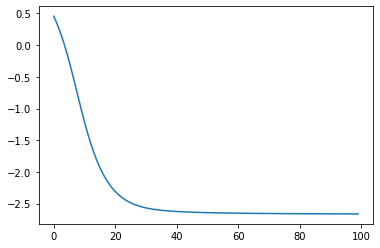

In [8]:
plt.plot(losses)

In [9]:
losses[-1]

tensor(-2.66264996, requires_grad=True)

In [10]:
w, v = np.linalg.eigh(H)

w[0]

-2.6666666666666674

In [11]:
v[:, 0]

tensor([ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.70710678+0.j,  0.        +0.j,  0.        +0.j], requires_grad=True)

In [12]:
ansatz_qnode(weights, check_state=True)

tensor([ 0.02473158+0.00367641j,  0.24406424+0.11463965j,
         0.19016448+0.44459137j, -0.23961655-0.10874607j,
         0.00458385-0.00692215j, -0.39910079+0.19018141j,
        -0.19773008-0.43575196j,  0.39890652-0.19958695j,
        -0.00722396+0.00946428j], requires_grad=True)

#### Problem Specific Ansatz

Earlier, we saw that the lowest-energy eigenstate of the Hamiltonian is
$$\displaystyle \frac{1}{\sqrt{2}} \begin{bmatrix}
0\\
0\\
-1\\
0\\
0\\
0\\
1\\
0\\
0\\
\end{bmatrix} = \frac{1}{\sqrt{2}} \left( -|rg\rangle + |gr\rangle\right)$$

Let's create an ansatz that is more optimal for creating this specific state

In [13]:
def ansatz_specific(params, check_state=False):
    qml.TRY(params[0], wires=1, subspace=[0, 2])
    qml.TAdd(wires=[1, 0])
    qml.TRY(params[1], wires=0, subspace=[0, 2])

    if check_state:
        return qml.state()

    return qml.expval(qml.THermitian(H, wires=[0, 1]))

In [14]:
ansatz_specific_qnode = qml.QNode(ansatz_specific, dev)

weights = np.random.normal(size=4)

opt = qml.GradientDescentOptimizer(stepsize=0.05)

n_its = 100

losses = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(ansatz_specific_qnode, weights)
    losses.append(_loss)
    
    if it % 5 == 0:
        print(f"Loss at iteration {it:2} = {_loss: .8f}")

Loss at iteration  0 = -1.28335299
Loss at iteration  5 = -1.98553410
Loss at iteration 10 = -2.38751239
Loss at iteration 15 = -2.56286033
Loss at iteration 20 = -2.62960570
Loss at iteration 25 = -2.65363528
Loss at iteration 30 = -2.66210948
Loss at iteration 35 = -2.66507603
Loss at iteration 40 = -2.66611185
Loss at iteration 45 = -2.66647319
Loss at iteration 50 = -2.66659920
Loss at iteration 55 = -2.66664314
Loss at iteration 60 = -2.66665846
Loss at iteration 65 = -2.66666381
Loss at iteration 70 = -2.66666567
Loss at iteration 75 = -2.66666632
Loss at iteration 80 = -2.66666655
Loss at iteration 85 = -2.66666662
Loss at iteration 90 = -2.66666665
Loss at iteration 95 = -2.66666666


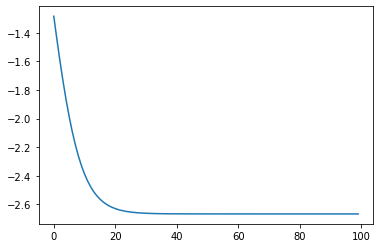

In [15]:
plt.plot(losses)

In [16]:
losses[-1]

tensor(-2.66666666, requires_grad=True)

In [17]:
w, v = np.linalg.eigh(H)

w[0]

-2.6666666666666674

In [18]:
v[:, 0]

tensor([ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.70710678+0.j,  0.        +0.j,  0.        +0.j], requires_grad=True)

In [19]:
ansatz_specific_qnode(weights, check_state=True)

tensor([ 1.11133692e-05+0.j,  0.00000000e+00+0.j, -7.07096719e-01+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         7.07116843e-01+0.j,  0.00000000e+00+0.j,  1.11130529e-05+0.j], requires_grad=True)

# Hamiltonian simulation for two color sources